### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np

## Carga de datos

In [2]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## Vectorización

In [3]:
# instanciamos un vectorizador
# ver diferentes parámetros de instanciación en la documentación de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidfvect = TfidfVectorizer()

In [4]:
# en el atributo `data` accedemos al texto
print(newsgroups_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [5]:
# con la interfaz habitual de sklearn podemos fitear el vectorizador
# (obtener el vocabulario y calcular el vector IDF)
# y transformar directamente los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)
# `X_train` la podemos denominar como la matriz documento-término

In [6]:
# recordar que las vectorizaciones por conteos son esparsas
# por ello sklearn convenientemente devuelve los vectores de documentos
# como matrices esparsas
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'Cantidad de documentos: {X_train.shape[0]}')
print(f'Tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
Cantidad de documentos: 11314
Tamaño del vocabulario (dimensionalidad de los vectores): 101631


In [7]:
# una vez fiteado el vectorizador, podemos acceder a atributos como el vocabulario
# aprendido. Es un diccionario que va de términos a índices.
# El índice es la posición en el vector de documento.
tfidfvect.vocabulary_['car']

25775

In [8]:
# es muy útil tener el diccionario opuesto que va de índices a términos
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [9]:
# en `y_train` guardamos los targets que son enteros
y_train = newsgroups_train.target
y_train[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [10]:
# hay 20 clases correspondientes a los 20 grupos de noticias
print(f'clases {np.unique(newsgroups_test.target)}')
newsgroups_test.target_names

clases [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Similaridad de documentos

In [11]:
# Veamos similaridad de documentos. Tomemos algún documento
idx = 4811
print(newsgroups_train.data[idx])

THE WHITE HOUSE

                  Office of the Press Secretary
                   (Pittsburgh, Pennslyvania)
______________________________________________________________
For Immediate Release                         April 17, 1993     

             
                  RADIO ADDRESS TO THE NATION 
                        BY THE PRESIDENT
             
                Pittsburgh International Airport
                    Pittsburgh, Pennsylvania
             
             
10:06 A.M. EDT
             
             
             THE PRESIDENT:  Good morning.  My voice is coming to
you this morning through the facilities of the oldest radio
station in America, KDKA in Pittsburgh.  I'm visiting the city to
meet personally with citizens here to discuss my plans for jobs,
health care and the economy.  But I wanted first to do my weekly
broadcast with the American people. 
             
             I'm told this station first broadcast in 1920 when
it reported that year's presidential elec

In [12]:
# midamos la similaridad coseno con todos los documentos de train
cossim = cosine_similarity(X_train[idx], X_train)[0]

In [13]:
# podemos ver los valores de similaridad ordenados de mayor a menos
np.sort(cossim)[::-1]

array([1.        , 0.70930477, 0.67474953, ..., 0.        , 0.        ,
       0.        ])

In [14]:
# y a qué documentos corresponden
np.argsort(cossim)[::-1]

array([4811, 6635, 4253, ..., 9019, 9016, 8748])

In [15]:
# los 5 documentos más similares:
mostsim = np.argsort(cossim)[::-1][1:6]

In [16]:
# el documento original pertenece a la clase:
newsgroups_train.target_names[y_train[idx]]

'talk.politics.misc'

In [17]:
# y los 5 más similares son de las clases:
for i in mostsim:
  print(newsgroups_train.target_names[y_train[i]])

talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc


### Modelo de clasificación Naïve Bayes

In [18]:
# es muy fácil instanciar un modelo de clasificación Naïve Bayes y entrenarlo con sklearn
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [19]:
# con nuestro vectorizador ya fiteado en train, vectorizamos los textos
# del conjunto de test
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target
y_pred =  clf.predict(X_test)

In [20]:
# el F1-score es una metrica adecuada para reportar desempeño de modelos de claificación
# es robusta al desbalance de clases. El promediado 'macro' es el promedio de los
# F1-score de cada clase. El promedio 'micro' es equivalente a la accuracy que no
# es una buena métrica cuando los datasets son desbalanceados
f1_score(y_test, y_pred, average='macro')

0.5854345727938506

### Consigna del desafío 1

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

**3**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**4**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.


# 1) Vectorización de documentos

In [64]:
# obtenemos 5 documentos al azar
rng = np.random.default_rng(seed=42)

subsample_indices = rng.choice(range(len(newsgroups_train.data)),size=5, replace=False)

subsample_indices

array([8754, 4965, 7404, 1009, 4899])

## Primer documento

In [65]:
# vemos su contenido
subsample_idx = 0

idx = subsample_indices[subsample_idx]

print(newsgroups_train.data[idx])


/(hudson)
/If someone inflicts pain on themselves, whether they enjoy it or not, they
/are hurting themselves.  They may be permanently damaging their body.

That is true.  It is also none of your business.  

Some people may also reason that by reading the bible and being a Xtian
you are permanently damaging your brain.  By your logic, it would be OK
for them to come into your home, take away your bible, and send you off
to "re-education camps" to save your mind from ruin.  Are you ready for
that?  





/(hudson)
/And why is there nothing wrong with it?  Because you say so?  Who gave you
/the authority to say that, and set the standard for morality?

Why?

Because: 
I am a living, thinking person able to make choices for myself.
I do not "need" you to show me what you think is the way; I have observed
too many errors in your thinking already to trust you to make up the
rules for me.

Because:
I set the standard for my *own* morality, and I permit you to do 
the same for yourself.  I

In [66]:
# qué clase es?
subsample_target = newsgroups_train.target[idx]

print(f"{subsample_target}: {newsgroups_train.target_names[subsample_target]}")

19: talk.religion.misc


In [67]:
# obtenemos los 5 más cercanos utilizando similaridad coseno

# util f
def top_k_most_similar(train_idx, X, top_k=5):
    cossim = cosine_similarity(X[train_idx], X)[0]

    # omitimos el que tiene similaridad 1 que es el documento mismo
    indices = np.argsort(cossim,)[-2:-(top_k+2):-1]

    return indices, cossim[indices]

most_similar, cossims = top_k_most_similar(idx, X_train, 5)

print("Similaridades coseno:", cossims)

Similaridades coseno: [0.49040531 0.48118373 0.46534812 0.45989485 0.45907434]


In [68]:
# mostramos las clases de los 5 más similares

for i, nn_idx in enumerate(most_similar):
    print(f"[{i+1}/5]: {newsgroups_train.target_names[newsgroups_train.target[nn_idx]]}")

[1/5]: talk.religion.misc
[2/5]: talk.religion.misc
[3/5]: talk.religion.misc
[4/5]: talk.politics.mideast
[5/5]: talk.religion.misc


In [69]:
# observamos los textos de cada uno

for i, nn_idx in enumerate(most_similar):
    print(f"********[{i+1}/5]********")
    print(newsgroups_train.data[nn_idx].strip('\n'), end='\n\n')

********[1/5]********
If I have a habit that I really want to break, and I am willing to
make whatever sacrifice I need to make to break it, then I do so.
There have been bad habits of mine that I've decided to put forth the
effort to break, and I've done so; there have been other bad habits
that I've decided are not worth the effort to break.  It's my choice,
either way.

I am my own master.  I choose what I want to do.  I weigh the benefits
of my actions against their consequences, and I use my experience to
help me deal with the unexpected, which in turn make me more experienced.

I don't always succeed, but I never fail, either -- I learn.

Do *you* have any habits you can't break?  Why not?


I have arrived at my own understanding of Christianity, just as you've
probably arrived at your own understanding of Islam that is most
likely very different from the way a Moslem thinks of his religion.
Are you "unable to master your lack of desire to understand even the
slightest concept of

Son todas discusiones teológicas y/o filosóficas. Incluso la del medio oriente, la única que no es de la misma categoría que el documento base, trata sobre cuestiones religiosas. Se concluye que los documentos en este caso son acertadamente cercanos.

Como nota de color, el 4º documento incluye otra discusión con "Hudson".

## Segundo documento

In [70]:
# vemos su contenido
subsample_idx = 1

idx = subsample_indices[subsample_idx]

print(newsgroups_train.data[idx])


No.  Plug the printer in the printer port, and the modem in the modem
port. ;)


In [71]:
# qué clase es?
subsample_target = newsgroups_train.target[idx]

print(f"{subsample_target}: {newsgroups_train.target_names[subsample_target]}")

4: comp.sys.mac.hardware


In [72]:
# obtenemos los 5 más cercanos utilizando similaridad coseno

most_similar, cossims = top_k_most_similar(idx, X_train, 5)

print("Similaridades coseno:", cossims)

Similaridades coseno: [0.36532782 0.3610905  0.35537084 0.3407098  0.3405298 ]


In [73]:
# mostramos las clases de los 5 más similares

for i, nn_idx in enumerate(most_similar):
    print(f"[{i+1}/5]: {newsgroups_train.target_names[newsgroups_train.target[nn_idx]]}")

[1/5]: comp.sys.mac.hardware
[2/5]: comp.sys.mac.hardware
[3/5]: comp.sys.ibm.pc.hardware
[4/5]: comp.sys.ibm.pc.hardware
[5/5]: comp.graphics


In [74]:
# observamos los textos de cada uno

for i, nn_idx in enumerate(most_similar):
    print(f"********[{i+1}/5]********")
    print(newsgroups_train.data[nn_idx].strip('\n'), end='\n\n')

********[1/5]********
Battery powered devices like the PowerBook are sometimes more sensitive to 
serial port weirdness.  I had trouble with connecting my Mac Plus to an HP 95LX
handheld.  Everything else worked okay on that port, but not the HP. (it runs
on two penlite batteries).  It turned out that the plus (by accident or by 
design flaw?) was putting a 4 volt bias on the serial port that was doing 
weird things to the HP (which has only 3v dc!).  The HP worked fine when 
connected to the printer port.  

Does your PB screen get dim or anything when connected to the device?  Have you 
tried using the printer port?

Good luck. 

--jamie

********[2/5]********
I have used both my serial ports with a modem and a serial printer, 
so I cannot use Appletalk.  Is there a Ethernet to Localtalk hardware
that will let me use the Ethernet port on my Q700 as a Localtalk 
port.  Until they come out with
satellite dishes that sit on your window & give you internet access
from your home, I won't 

El documento original (muy corto) versa sobre 3 cuestiones: puertos, impresoras y modems. Los 5 documentos más similares todos tratan alguna/s de estas 3 temáticas, independientemente de su categoría.

## Tercer documento

In [75]:
# vemos su contenido
subsample_idx = 2

idx = subsample_indices[subsample_idx]

print(newsgroups_train.data[idx])

Hello.

      Is it possible to know minimize program manager when starting an
      application and to restore it when the application is ended ?
      If possible, please tell me how to do it !




In [76]:
# qué clase es?
subsample_target = newsgroups_train.target[idx]

print(f"{subsample_target}: {newsgroups_train.target_names[subsample_target]}")

2: comp.os.ms-windows.misc


In [77]:
# obtenemos los 5 más cercanos utilizando similaridad coseno

most_similar, cossims = top_k_most_similar(idx, X_train, 5)

print("Similaridades coseno:", cossims)

Similaridades coseno: [0.26825979 0.22977881 0.22486184 0.22486184 0.22188792]


In [78]:
# mostramos las clases de los 5 más similares

for i, nn_idx in enumerate(most_similar):
    print(f"[{i+1}/5]: {newsgroups_train.target_names[newsgroups_train.target[nn_idx]]}")

[1/5]: comp.windows.x
[2/5]: comp.windows.x
[3/5]: comp.graphics
[4/5]: sci.med
[5/5]: comp.windows.x


In [79]:
# observamos los textos de cada uno

for i, nn_idx in enumerate(most_similar):
    print(f"********[{i+1}/5]********")
    print(newsgroups_train.data[nn_idx].strip('\n'), end='\n\n')

********[1/5]********
I need to have PCs and SPARCstations run the same application ( namely
MicroSoft Project ). The original system ran on the PC. Now it needs to
be expanded to allow UNIX users to work with the application. The
current proposal is to use DESQview/X as a display server for the
application.

I would like to know your experiences with using DESQview/X to run an
application on a PC and displaying on a SPARCstation. I've heard that
the network traffic is slow.

Replies only by e-mail please.

Thanks, in advance.

********[2/5]********
What "it may think is right" may be exactly what the user wants.
Assuming that your application "has reason to know better" is, IMHO,
anti-social.  If I start your application with a -geometry option are
you going to ignore that as well?

There's really no way to force a window manager to do much of anything
if it's managing your window.  You can ask, you can hint, but there's
no guarantee that you're going to get what you want.

********[3

3 de los 5 documentos mencionan, al igual que el base, temas de aplicaciones. Otros 2 son simplemente "Hello" que por normalización de documentos es esperable que tengan un peso fuerte, pero no son documentos "similares". Podría incluso argumentarse que no deberían pertenecer al dataset.

## Cuarto documento

In [80]:
# vemos su contenido
subsample_idx = 3

idx = subsample_indices[subsample_idx]

print(newsgroups_train.data[idx])

[followups to talk.politics.guns]

rl> Russell Lawrence
kr> Karl Rominger

kr> I support the right of any citizen with out a criminal history to own and
    use firearms, regardless of race, gender, and RELIGION.

rl> Thanks for admitting that you, yourself, adhere to an illogical dogma.

  Well, folks in t.p.guns, want to show how Russell's "illogical dogma" is
  wrong?



In [81]:
# qué clase es?
subsample_target = newsgroups_train.target[idx]

print(f"{subsample_target}: {newsgroups_train.target_names[subsample_target]}")

16: talk.politics.guns


In [82]:
# obtenemos los 5 más cercanos utilizando similaridad coseno

most_similar, cossims = top_k_most_similar(idx, X_train, 5)

print("Similaridades coseno:", cossims)

Similaridades coseno: [0.14651819 0.14582284 0.14413217 0.14348974 0.13924434]


In [83]:
# mostramos las clases de los 5 más similares

for i, nn_idx in enumerate(most_similar):
    print(f"[{i+1}/5]: {newsgroups_train.target_names[newsgroups_train.target[nn_idx]]}")

[1/5]: talk.politics.guns
[2/5]: talk.politics.guns
[3/5]: alt.atheism
[4/5]: talk.politics.guns
[5/5]: talk.politics.guns


In [84]:
# observamos los textos de cada uno

for i, nn_idx in enumerate(most_similar):
    print(f"********[{i+1}/5]********")
    print(newsgroups_train.data[nn_idx].strip('\n'), end='\n\n')

********[1/5]********
 >This argument sounds very stupid.. if the ability to make guns from
 >"simple metalworking" was easy,  then Drug dealers would make their own 
 >wouldn't they???.. why spend hundreds of dollars buying a gun that
 >somebody else made cheap and is selling it to you at an
 >exorbitant markup???... The simple truth of the matter is, that regardless
 >of how easy it is to make guns, banning guns will reduce the 
 >the number of new guns and seriuosly impede the efforts of a 
 >killer intent on buying a weapon....
 >To show why the tools argument is the silliest i have ever seen.. take an
 >analogy from computer science... almost every computer science major
 >can write a "wordprocessor" yet we(comp sci majors)  would willingly pay 3  
 >to 400 bucks for a professional software like wordperfect... why don't we  
 >just all write our own software???...... Because it is highly  
 >inconvinient!!!..
 >Same with guns... secondly.. how does one get this gunpowder for the 


Al igual que el documento base, la mayoría de estos documentos tratan sobre portación de armas. El de religión, si bien no trata sobre esto, sí habla sobre guerras y religión, ambos temas relacionados al documento base.

## Quinto documento

In [85]:
# vemos su contenido
subsample_idx = 4

idx = subsample_indices[subsample_idx]

print(newsgroups_train.data[idx])

...

Haven't you read any of Noam Chomsky's works? A widely used information net
outside the control of the 'right people' is unthinkable. Hundreds of billions
of dollars will be spent to wipe it out, sorry, 'regulate and order it' once
the major media and poitical powers wake up to the efect it can have.

If you can't be bothered reading, get the video "Manufacturing Consent".


In [86]:
# qué clase es?
subsample_target = newsgroups_train.target[idx]

print(f"{subsample_target}: {newsgroups_train.target_names[subsample_target]}")

11: sci.crypt


In [87]:
# obtenemos los 5 más cercanos utilizando similaridad coseno

most_similar, cossims = top_k_most_similar(idx, X_train, 5)

print("Similaridades coseno:", cossims)

Similaridades coseno: [0.19650787 0.19504841 0.18794282 0.18754933 0.18753528]


In [88]:
# mostramos las clases de los 5 más similares

for i, nn_idx in enumerate(most_similar):
    print(f"[{i+1}/5]: {newsgroups_train.target_names[newsgroups_train.target[nn_idx]]}")

[1/5]: talk.politics.mideast
[2/5]: sci.crypt
[3/5]: alt.atheism
[4/5]: sci.crypt
[5/5]: sci.crypt


In [89]:
# observamos los textos de cada uno

for i, nn_idx in enumerate(most_similar):
    print(f"********[{i+1}/5]********")
    print(newsgroups_train.data[nn_idx].strip('\n'), end='\n\n')

********[1/5]********
[After a small refresh Hasan got on the track again.]




   |>    |> I get the impression Hasan realized he goofed and is now
   |>    |> trying to drop the thread. Let him. It might save some
   |>    |> miniscule portion of his sorry face.

   |>    Not really. since i am a logical person who likes furthering himself
   |>    from any "name calling", i started trashing any article that contains
   |>    such abuses without responding to, and sometimes not even reading articles 
   |>    written by those who acquired such bad habits from bad company!
   |> 
   |> Ah, but in my followup on the subject (which you, by the way, never bothered
   |> responding to..) there was no name-calling. Hence the assumption.
   |> Do you feel more up to it now, so that we might have an answer?
   |> Or, to refresh your memory, does the human right issue in the area
   |> apply to Palestinians only? Also, do you claim there is such a thing as 
   |> forfeiting a human right? If 

En este caso algunos documentos efectivamente hablan sobre libertad y "verdad" (tópicos complicados) como en el documento base, pero no todos. Uno de ellos se limita a cuestionar, desde un punto de vista histórico, la consistencia del cristianismo, lo cual podría estar relacionado pero solo tangencialmente.

En general observamos que es obtener los documentos similares utilizando la similaridad coseno sobre vectorización TF-IDF es una estrategia decente en promedio, aunque puede tener fallas. Hacemos la distinción, sin embargo, de que predecir la categoría de los documentos y capturar la semántica particular de cada uno son problema distintos y de diferente dificultad.

# 2) Modelo zero-shot

In [47]:
# macro-F1 de predictor random en base a distribución empírica de targets en train
f1_score(y_test, rng.choice(y_train, size=len(y_test), replace=True), average='macro')

0.048504132133915516

In [48]:
class ZeroShotPredictor():
    def __init__(self):
        pass

    def fit(self, X_train, y_train):
        self.x = X_train
        self.y = y_train
        return self

    def predict(self, X_test):
        # sacamos el indice de la fila con máxima similaridad, para cada columna
        nn = cosine_similarity(self.x, X_test).argmax(axis=0)

        # la usamos para indexar los targets y devolvemos eso
        return self.y[nn]

In [49]:
# instanciamos
zsp = ZeroShotPredictor().fit(X_train, y_train)

In [50]:
# predecimos
y_pred = zsp.predict(X_test)

# evaluamos
f1_score(y_test, y_pred, average='macro')

0.5049911553681621

Observamos que tiene un desempeño un poco peor (0.505) que el MultinomialNB antes mostrado (0.585) pero los resultados son razonables y mucho mejores que el azar.

# 3) Modelo Naïve Bayes y comparación de hiperparámetros

## Baseline: TF-IDF + MultinomialNB, ambos con valores default

In [51]:
from sklearn.pipeline import make_pipeline

baseline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# utils
def eval_model(model):
    model.fit(newsgroups_train.data, y_train)

    y_pred = model.predict(newsgroups_test.data)

    return f1_score(y_test, y_pred, average='macro')

eval_model(baseline)

0.5854345727938506

Reproducimos el resultado anterior.

## ComplementNB

In [52]:
# observamos desbalance en las clases
for y in (y_train, y_test):
    frecs = np.bincount(y)
    print(frecs.max() / frecs.min()) # en un dataset balanceado esto da ~1

1.5915119363395225
1.5896414342629481


In [53]:
eval_model(make_pipeline(
    TfidfVectorizer(),
    ComplementNB()
))

0.692953349950875

Observamos que ComplementNB, que fue [diseñado para mejorar la performance del MultinomialNB sobre datasets desbalanceados](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes), presenta una notable mejora de performance, por lo que lo preferimos.

Esto es entendible dado que el dataset de 20 newsgroups dataset es *un poco* desbalanceado, donde la clase más representada es ~60% más popular que la menos representada.

## Exploración de hiperparámetros: ComplementNB

Los dos hiperparámetros principales de ComplementNB son el $\alpha$ de smoothing y si se aplica una segunda normalización de los pesos (por default no se hace).

In [54]:
# segunda normalización
eval_model(make_pipeline(
    TfidfVectorizer(),
    ComplementNB(norm=True)
))

0.6897777757684624

El resultado es un poco peor, se descarta.

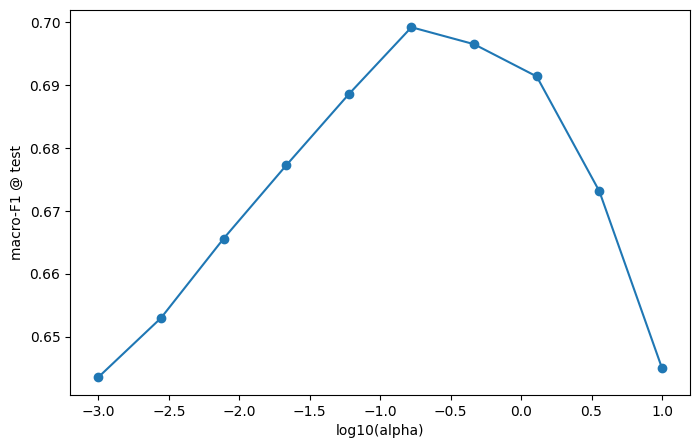

In [55]:
# mini grid-search sobre valores de alpha
import matplotlib.pyplot as plt

exps = np.linspace(-3, 1, 10)

results = [
    eval_model(make_pipeline(TfidfVectorizer(),ComplementNB(alpha=10.0**exp)))
    for exp in exps
]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(exps, results, marker='o')
ax.set_xlabel('log10(alpha)')
ax.set_ylabel('macro-F1 @ test')
plt.show()

In [56]:
# vemos bien dónde ocurre el máximo y cuánto vale
10**exps[np.argmax(results)].item(), max(results)

(0.1668100537200059, 0.6991532326747671)

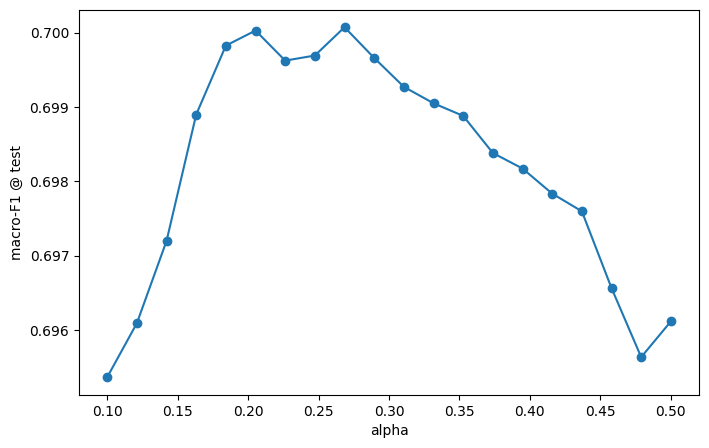

In [57]:
# repetimos búsqueda, ahora lineal
alphas = np.linspace(0.1,0.5,20)

results = [
    eval_model(make_pipeline(TfidfVectorizer(),ComplementNB(alpha=alpha)))
    for alpha in alphas
]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(alphas, results, marker='o')
ax.set_xlabel('alpha')
ax.set_ylabel('macro-F1 @ test')
plt.show()

In [58]:
# vemos bien dónde ocurre el máximo y cuánto vale
best_alpha = alphas[np.argmax(results)].item()
best_alpha, max(results)

(0.26842105263157895, 0.7000714320337217)

Observamos que el resultado es apenas mejor, se logra un máximo de 0.7 (por sobre ~0.693) y sobre una curva bastante irregular cerca del pico.

## Exploración de hiperparámetros: TF-IDF

In [59]:
# IDF mínimo y máximo
np.sort(1/tfidfvect.idf_)[[0,-1]]

array([0.10372651, 0.84935284])

In [180]:
modifs = [
    {'norm':'l1'}, # norma L1
    {'norm':None}, # sin normalización
    {'sublinear_tf':True}, # log-TF
    {'binary':True}, # binary TF
    {'max_features': 90000}, # vocabulario un poco más chico
    *[{'analyzer':opt, 'ngram_range':gram_range} for opt in ('char','char_wb') for gram_range in ((2,2),(2,3),(3,3))], # bigramas, trigramas
    *[{'min_df':min_df, 'max_df':max_df} for min_df in (1,2,5,10) for max_df in (0.8,1.0)], # min y max ocurrencias
]


for modif in modifs:
    res = eval_model(make_pipeline(
        TfidfVectorizer(**modif),
        ComplementNB(alpha=best_alpha)
    ))

    print(modif, round(res, 4))

{'norm': 'l1'} 0.6867
{'norm': None} 0.6163
{'sublinear_tf': True} 0.6992
{'binary': True} 0.6965
{'max_features': 90000} 0.7
{'analyzer': 'char', 'ngram_range': (2, 2)} 0.3687
{'analyzer': 'char', 'ngram_range': (2, 3)} 0.5663
{'analyzer': 'char', 'ngram_range': (3, 3)} 0.5891
{'analyzer': 'char_wb', 'ngram_range': (2, 2)} 0.3691
{'analyzer': 'char_wb', 'ngram_range': (2, 3)} 0.5701
{'analyzer': 'char_wb', 'ngram_range': (3, 3)} 0.5923
{'min_df': 1, 'max_df': 0.8} 0.6998
{'min_df': 1, 'max_df': 1.0} 0.7001
{'min_df': 2, 'max_df': 0.8} 0.6964
{'min_df': 2, 'max_df': 1.0} 0.6964
{'min_df': 5, 'max_df': 0.8} 0.6824
{'min_df': 5, 'max_df': 1.0} 0.6828
{'min_df': 10, 'max_df': 0.8} 0.6645
{'min_df': 10, 'max_df': 1.0} 0.6652


Son todos entre peores y mucho peores, nos quedamos con los valores default y el ComplementNB con $\alpha \approx 0.2684$. El único que parece que da mejor en realidad es el original, con min=1 y max=100%.

# 4) Comparación de similaridades entre palabras

In [61]:
word_tfidf = X_train.T.tocsr()
word_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1103627 stored elements and shape (101631, 11314)>

In [160]:
import pandas as pd

idx = 64015

most_similar, cossims = top_k_most_similar(idx, word_tfidf, 5)


print(f"Palabras más similares para '{idx2word[idx]}'")
pd.DataFrame({
    'cosine': cossims,
    'word': [idx2word[x] for x in most_similar]
})

Palabras más similares para 'multiprocessing'


,cosine,word
0,0.882783,rumored
1,0.634251,preemptive
2,0.607151,multithreading
3,0.495139,cairo
4,0.485297,reliance


Aparecen algunas como "cairo" y "rumored" que resultan extrañas (seguramente describiendo cuestiones relacionadas en pocos documentos). Los términos "preemptive" y "multithreading" son sumamente importantes en el contexto del procesamiento en paralelo. "Reliance" tiene sentido en un contexto de procesamiento concurrente.

In [111]:
idx = 55888

most_similar, cossims = top_k_most_similar(idx, word_tfidf, 5)


print(f"Palabras más similares para '{idx2word[idx]}'")
pd.DataFrame({
    'cosine': cossims,
    'word': [idx2word[x] for x in most_similar]
})

Palabras más similares para 'lazy'


,cosine,word
0,0.488973,uneducated
1,0.473226,overconfident
2,0.411052,imperialist
3,0.402338,rapists
4,0.388848,colonial


Vemos que "lazy" se relaciona con otros peyorativos, aunque aparecen "colonial" e "imperialist" que pueden estar sesgados por las clases de documentos cubiertas por el dataset (también utilizadas en estos casos como peyorativas).

In [162]:
idx = 78922

most_similar, cossims = top_k_most_similar(idx, word_tfidf, 5)


print(f"Palabras más similares para '{idx2word[idx]}'")
pd.DataFrame({
    'cosine': cossims,
    'word': [idx2word[x] for x in most_similar]
})

Palabras más similares para 'robbers'


,cosine,word
0,0.899758,ceaseless
1,0.783110,overheated
2,0.434937,robber
3,0.430511,woodshed
4,0.430511,homeowner


Se observan lugares y términos relacionados al robo como "robber" (el singular), "woodshed" y "homeowner". "Overheated" y "Ceaseless" pueden estar referidos a circunstancias.

In [129]:
idx = 39581

most_similar, cossims = top_k_most_similar(idx, word_tfidf, 5)


print(f"Palabras más similares para '{idx2word[idx]}'")
pd.DataFrame({
    'cosine': cossims,
    'word': [idx2word[x] for x in most_similar]
})

Palabras más similares para 'fascism'


,cosine,word
0,0.657663,fascist
1,0.642496,practiced
2,0.548046,ending
3,0.536979,discrimination
4,0.402256,hennessy


Nuevamente un término de connotación negativa, que aprece asociado a verbos como "practiced" o situaciones como "ending" (fin de) o directamente términos asociados a prácticas fascistas como "discrimination". "hennessy" probablemente sea un nombre.

In [176]:
for news in newsgroups_train.data:
    if 'hennessy' in news.lower():
        print(news)
        print("*"*100)

On Sat, 17 Apr 1993 20:42:58 GMT, Greg Hennessy observed:
: #Tells you something about the fascist politics being practiced ....

: Ah, ending discrimination is now fascism. 

Is that what they called it when Truman forced integration of the
armed forces, despite the opposition of Congress and most of the
American public at that time?

--
Michael D. Adams          (starowl@a2i.rahul.net)          Enterprise, Alabama
****************************************************************************************************


Efectivamente era un nombre (apellido en realidad) que figura en un artículo en el que se menciona 'fascism'.